Import all the necessary stuff,

In [1]:
import matplotlib.pyplot as plt
from kadlu.sound.sound_propagation import TLCalculator, Seafloor
from kadlu.geospatial.ocean import Ocean

/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/data_util.py:43: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")
/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/data_util.py:43: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")


Create a simplified, uniform, seabed with the following properties: 
  
  * thickness of 2 km
  * sound speed of 1,700 m/s
  * density of 1.5 g/cm^3
  * attenuation of 0.5 dB per wavelength,

In [2]:
s = Seafloor(thickness=500, c=1700, density=1.5, loss=0.5)

Create a simplified, uniform, ocean volume which is 3 km deep everywhere

In [3]:
o = Ocean(default=False, load_bathymetry=-3000)

In [4]:
tl = TLCalculator(ocean=o, seafloor=s, sound_speed=1500,
    radial_bin=100, radial_range=10e3, 
    angular_bin=10, angular_range=15,
    starter_method='GAUSSIAN',
    vertical_bin=10, 
    verbose=False, progress_bar=False)

In [5]:
tl.run(frequency=200, source_depth=-2, source_lat=45, source_lon=60, vertical_slice=True)

/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/sound/pe/propagator.py:225: RuntimeWarning: overflow encountered in cosh
  sech2 = 1. / np.cosh(0.5 * h / ld)
/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/sound/sound_propagation.py:413: RuntimeWarning: divide by zero encountered in log10
  TL = 20 * np.log10(np.abs(TL))


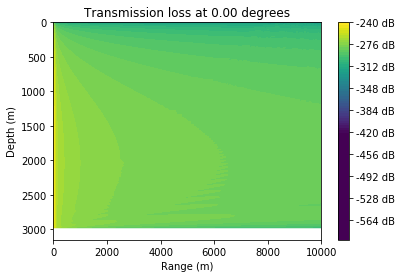

In [6]:
fig = tl.plot_vertical(show_bathy=True)

In [7]:
from datetime import datetime

o = Ocean(default=False, cache=True, fetch=True, load_bathymetry='chs', 
          south=43.53, north=44.29, west=-59.84, east=-58.48)


CA2_4400N06000W.tif: downloading 4/4 from CHS NONNA-100...
CA2_4300N05900W.tif processed and inserted 0 rows.	798620 null values removed, 203381 duplicate rows ignored
CA2_4300N06000W.tif processed and inserted 0 rows.	967380 null values removed, 34621 duplicate rows ignored
CA2_4400N05900W.tif processed and inserted 0 rows.	973710 null values removed, 28291 duplicate rows ignored
CA2_4400N06000W.tif processed and inserted 0 rows.	954562 null values removed, 47439 duplicate rows ignored


Let us display the bathymetry

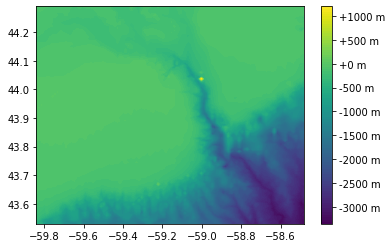

In [8]:
import numpy as np

lat = np.linspace(43.53, 44.29, 100)
lon = np.linspace(-59.84, -58.48, 100)
bathy = o.bathy(lat=lat, lon=lon, grid=True)

fig = plt.contourf(lon, lat, bathy, 100)
plt.colorbar(fig, format='%+2.0f m')
plt.show()

In [9]:
tl = TLCalculator(ocean=o, seafloor=s, sound_speed=1500,
    radial_bin=100, radial_range=50e3, 
    angular_bin=10, angular_range=10,
    starter_method='GAUSSIAN',
    vertical_bin=10, 
    verbose=False, progress_bar=False)

In [ ]:
tl.run(frequency=200, source_depth=-2, source_lat=43.9, source_lon=-59.2, vertical_slice=True)

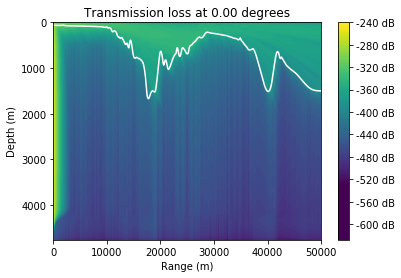

In [13]:
fig = tl.plot_vertical(angle=0, show_bathy=True)